In [1]:
import sys
sys.path.append("..")
from components.visualiser import Visualiser
from components.decisions import DecisionMaker, DecisionMakerVisualiser
from data_processor import DataProcessor
# Import lava related libraries
import numpy as np
from lava.magma.core.run_configs import Loihi2SimCfg
from lava.magma.core.run_conditions import RunSteps
from lava.proc import io
from lava.lib.dl import netx, slayer
import torch

/home/george/anaconda3/envs/lava0.5/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sample_length = 1200

# Create a random input array of spikes
# a = torch.empty(input_shape, sample_length).uniform_(0, 1)
# inp_array = torch.bernoulli(a).numpy()

# Use a collected sample to test
d = DataProcessor.load_data_np("/home/george/Documents/FrankaLava/data/Natural_Processed_Accelerations_4x4_pooling/0-0-3.npy")
y_size, x_size = np.shape(d.data)
spike = d.create_events()
inp_array = spike.fill_tensor(torch.zeros(1, y_size, x_size, sample_length, requires_grad=False)).reshape(-1, sample_length)

input_shape = y_size * x_size

source = io.source.RingBuffer(data=inp_array)
vis = Visualiser(in_shape=(input_shape,), sample_length=sample_length, window_size=50)
# decision_vis = DecisionMakerVisualiser(in_shape=(input_shape,))

decision = DecisionMaker(in_shape=source.s_out.shape)

In [3]:
source.s_out.connect(vis.a_in)
source.s_out.connect(decision.a_in)
# source.s_out.connect(decision_vis.a_in)

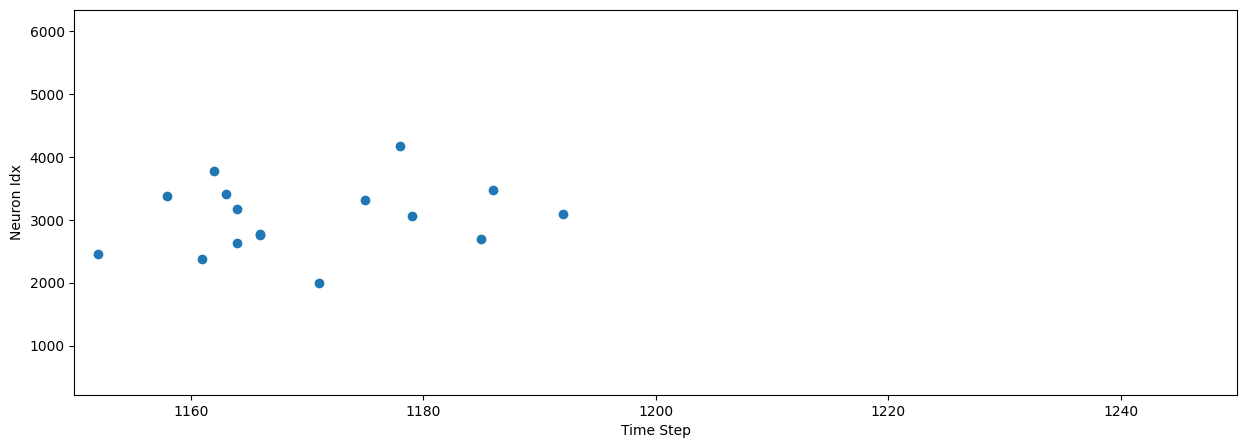

In [4]:
run_condition = RunSteps(num_steps=sample_length)

# Map the defined encoder and adapter to their proc models
run_config = Loihi2SimCfg(select_tag='fixed_pt', select_sub_proc_model=True)

#################################################
# Run network
#################################################
# Run network
print("Running network")

source.run(condition=run_condition, run_cfg=run_config)

source.stop()